#### Interpreting what convnets learn
A fundamental problem when building a computer vision application is that of interpretability: why did your classifier think a particular image contained a fridge, when all you can see is a truck? This is especially relevant to use cases where deep learning is used to complement human expertise, such as in medical imaging use cases. We will end this chapter by getting you familiar with a range of different techniques for visualizing what convnets learn and understanding the decisions they make. <br>
It’s often said that deep learning models are “black boxes”: they learn representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep learning models, it’s definitely not true for convnets. The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. Since 2013, a wide array of techniques has been developed for visualizing and interpreting these representations. We won’t survey all of them, but we’ll cover three of the most accessible and useful ones:
- **Visualizing intermediate convnet outputs (intermediate activations)**—Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters
- **Visualizing convnet filters**—Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to
- **Visualizing heatmaps of class activation in an image**—Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images

For the first method—activation visualization—we’ll use the small convnet that we trained from scratch on the dogs-versus-cats classification problem in section 8.2. For the next two methods, we’ll use a pretrained Xception model.

##### Visualizing intermediate activations
- Visualizing intermediate activations consists of displaying the values returned by various convolution and pooling layers in a model, given a certain input (the output of a layer is often called its **activation**, the output of the activation function). 
- This gives a view into how an input is decomposed into the different filters learned by the network. 
- We want to visualize feature maps with three dimensions: **width, height, and depth (channels)**. 
- Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image. 
- Let’s start by loading the model that you saved in section 8.2:

In [1]:
from tensorflow import keras

model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

Next, we’ll get an input image—a picture of a cat, not part of the images the network was trained on.

##### Preprocessing a single image

In [4]:
from tensorflow import keras
import numpy as np

# Download a test image.
img_path = keras.utils.get_file(fname="cat.jpg",
                                 origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    # Open the image file and resize it.
    img = keras.utils.load_img(img_path, target_size=target_size)
    # Turn the image into a float32 numpy array of shape(180, 180, 3).
    array = keras.utils.img_to_array(img)
    # Add a dimension to transorm the array into a “batch” of a single sample. Its shape is now (1, 180, 180, 3).
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

Let’s display the picture.

##### Displaying the test picture

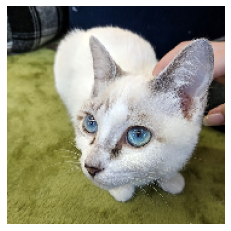

In [5]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In order to extract the feature maps we want to look at, we’ll create a Keras model that takes batches of images as input, and that outputs the activations of all convolution and pooling layers.

##### Instantiating a model that returns layer activations

In [6]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
# Extract the outputs of all Conv2D and MaxPooling2D layers and put them in a list.
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Create a model that will return these outputs, given the model input.
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

- When fed an image input, this model returns the values of the layer activations in the original model, as a list. 
- This is the first time you’ve encountered a **multi-output model** in this book in practice since you learned about them in chapter 7; until now, the models you’ve seen have had exactly one input and one output. 
- This one has one input and nine outputs: **one output per layer activation**.

##### Using the model to compute layer activations

In [7]:
# Return a list of nine NumPy arrays: one array per layer activation.
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for the cat image input:

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


It’s a 178 × 178 feature map with 32 channels. Let’s try plotting the fifth channel of the activation of the first layer of the original model.

##### Visualizing the fifth channel

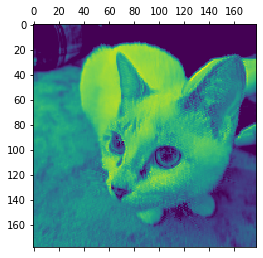

In [10]:
# Fifth channel of the activation of the first layer on the test cat picture
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

This channel appears to encode a diagonal edge detector—but note that your own channels may vary, because the specific filters learned by convolution layers aren’t deterministic. <br>
Now, let’s plot a complete visualization of all the activations in the network. We’ll extract and plot every channel in each of the layer activations, and we’ll stack the results in one big grid, with channels stacked side by side.

##### Visualizing every channel in every intermediate activation

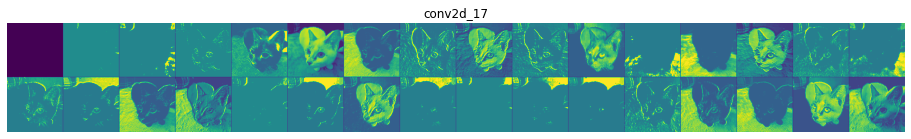

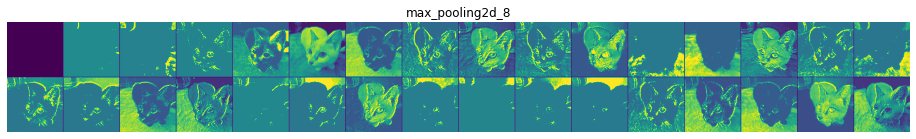

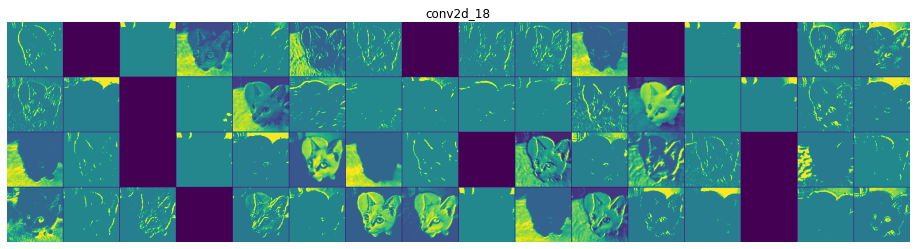

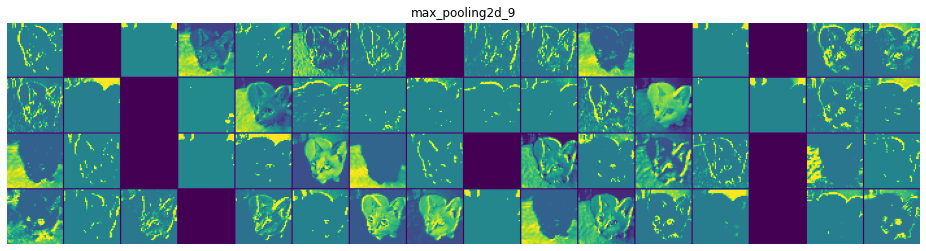

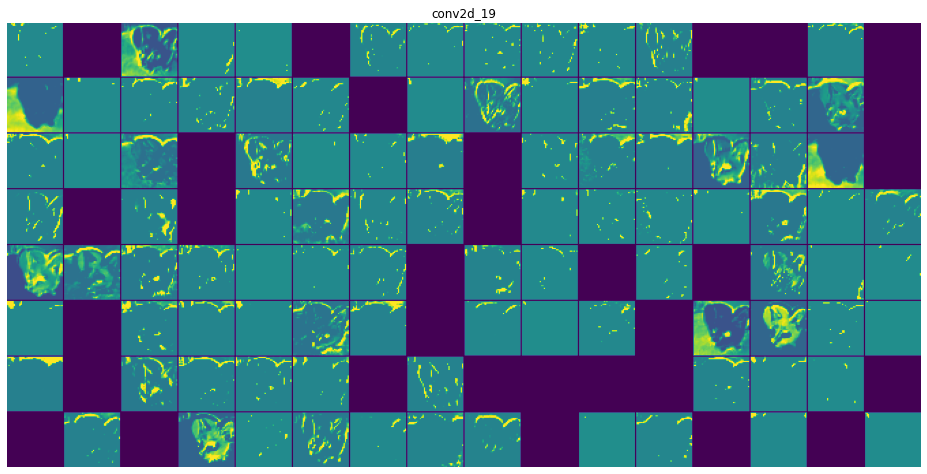

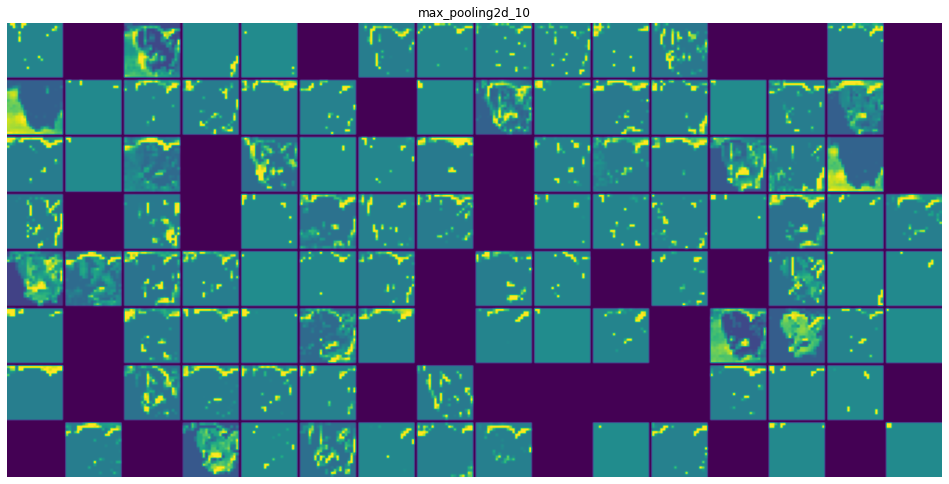

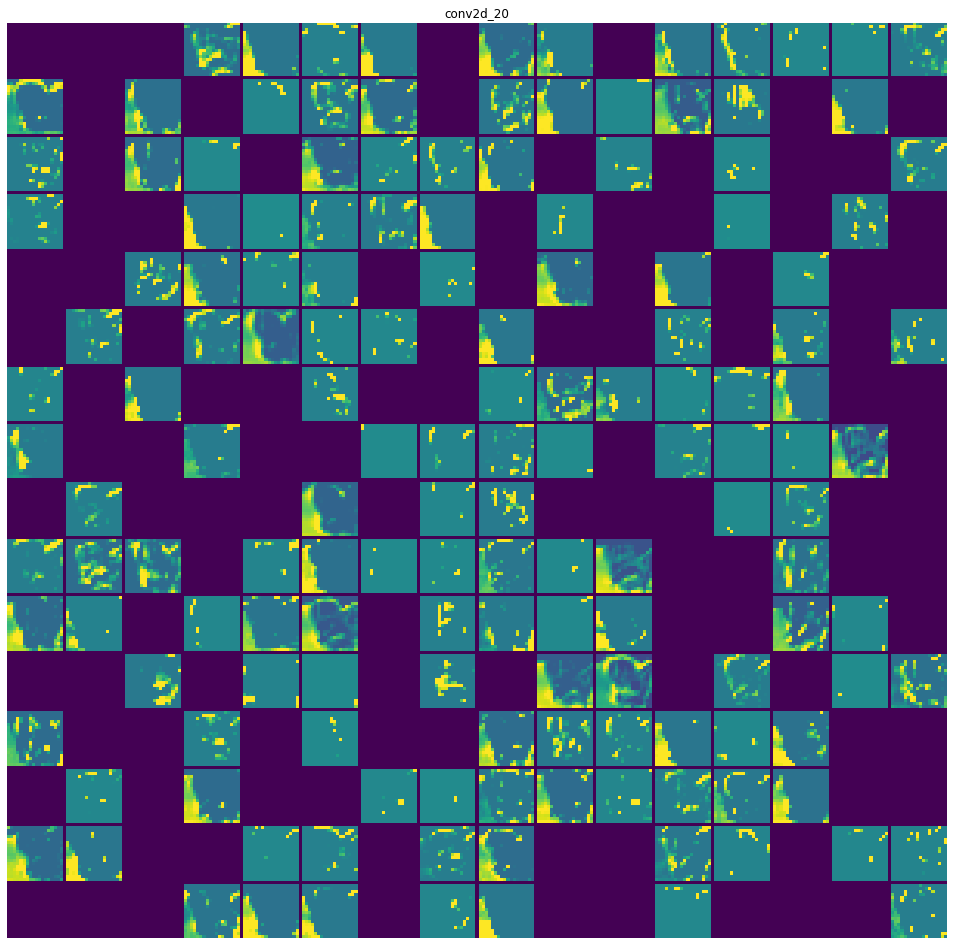

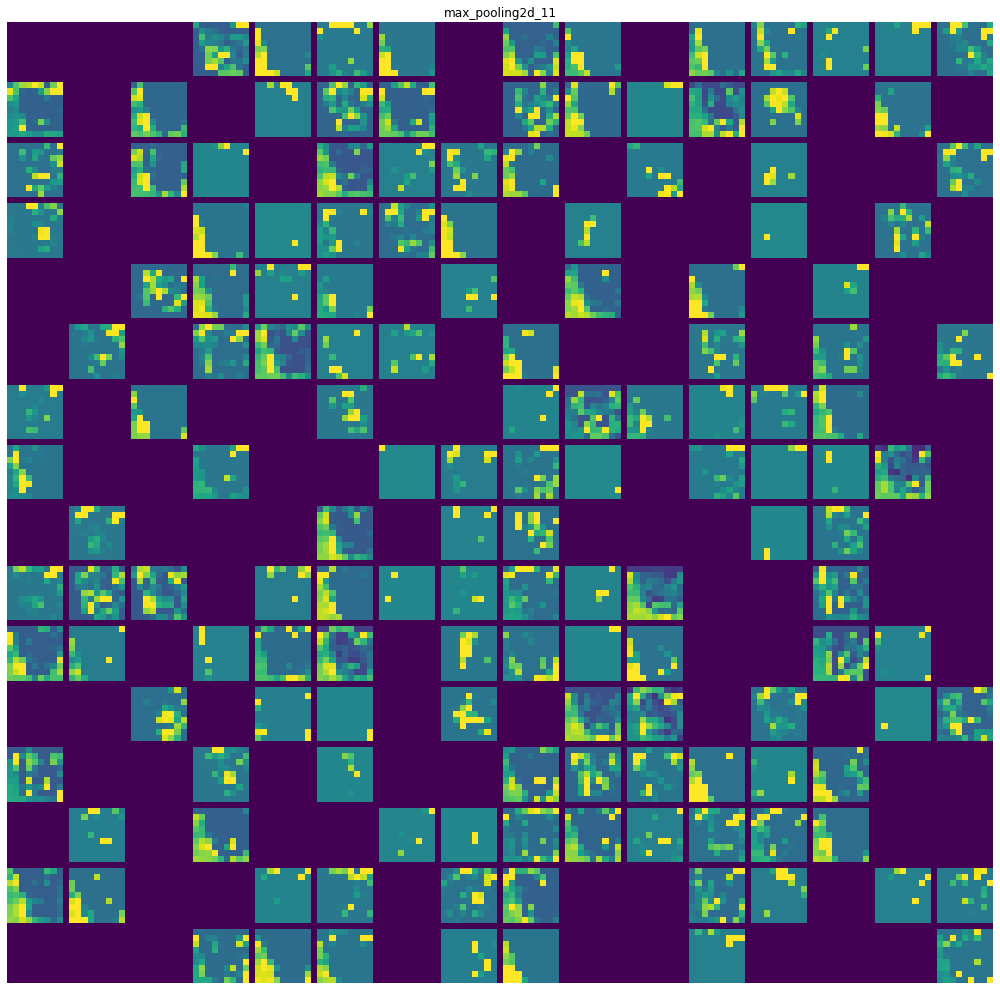

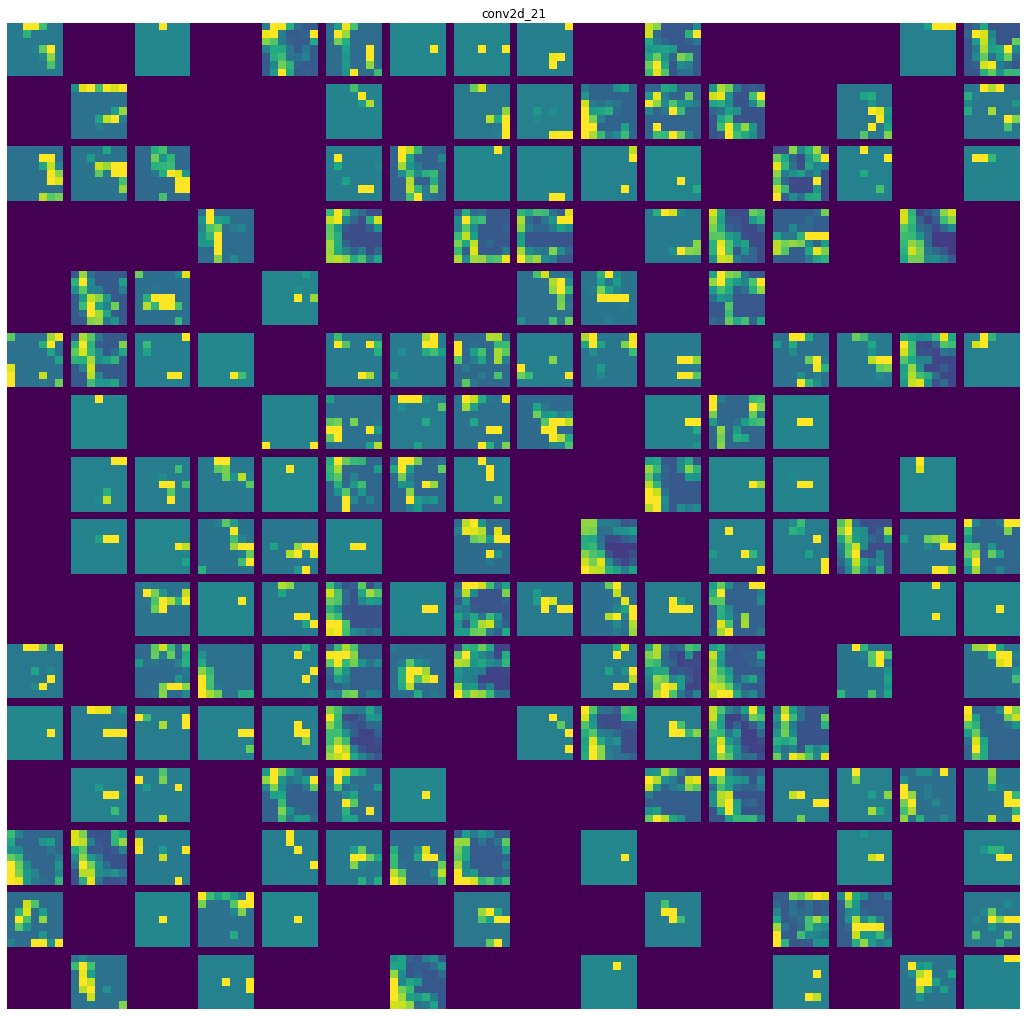

In [11]:
images_per_row = 16
# Iterate over the activations (and the names of the corresponding layers).
for layer_name, layer_activation in zip(layer_names, activations):
    # The layer activation has shape (1, size, size, n_features).
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    # Prepare an empty grid for displaying all the channels in this activation.
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy() # This is a single channel (or feature).
            # Normalize channel values within the [0, 255] range. All zero channels are kept at zero.
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            # Place the channel matrix in the empty grid we prepared.
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    # Display the grid for the layer.
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

**Every channel of every layer activation on the test cat picture**

There are a few things to note here:
- The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
- As you go deeper, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Deeper presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
- The sparsity of the activations increases with the depth of the layer: in the first layer, almost all filters are activated by the input image, but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

- We have just evidenced an important universal characteristic of the representations learned by deep neural networks: **the features extracted by a layer become increasingly abstract with the depth of the layer.** 
- **The activations of higher layers carry less and less information about the specific input being seen, and more and more information about the target (in this case, the class of the image: cat or dog)**. 
- A deep neural network effectively acts as an information distillation pipeline, with raw data going in (in this case, RGB pictures) and being repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and useful information is magnified and refined (for example, the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were present in it (bicycle, tree) but can’t remember the specific appearance of these objects. In fact, if you tried to draw a generic bicycle from memory, chances are you couldn’t get it even remotely right, even though you’ve seen thousands of bicycles in your lifetime (see, for example, figure 9.15). Try it right now: this effect is absolutely real. Your brain has learned to completely abstract its visual input—to transform it into high-level visual concepts while filtering out irrelevant visual details—making it tremendously difficult to remember how things around you look.

![](./chapter_images/9.15.png)

#### Visualizing convnet filters
Another easy way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with **gradient ascent in input space**: applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to. <br>
Let’s try this with the filters of the Xception model, pretrained on ImageNet. The process is simple: we’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then we’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. This will be our second example of a low-level gradient descent loop leveraging the **GradientTape** object (the first one was in chapter 2).

First, let’s instantiate the Xception model, loaded with weights pretrained on the ImageNet dataset.

##### Instantiating the Xception convolutional base

In [12]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False) # The classification layers are irrelevant for this use case, so we don’t include the top stage of the model.

83697664/83683744 [==============================] - 50s 1us/step


We’re interested in the convolutional layers of the model—the **Conv2D** and **SeparableConv2D** layers. We’ll need to know their names so we can retrieve their outputs. Let’s print their names, in order of depth.

##### Printing the names of all convolutional layers in Xception

In [13]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


You’ll notice that the SeparableConv2D layers here are all named something like block6_sepconv1, block7_sepconv2, etc. Xception is structured into blocks, each containing several convolutional layers. <br>
Now, let’s create a second model that returns the output of a specific layer—a **feature** extractor model. Because our model is a Functional API model, it is inspectable: we can query the output of one of its layers and reuse it in a new model. No need to copy the entire Xception code.

##### Creating a feature extractor model

In [14]:
layer_name = "block3_sepconv1" # You could replace this with the name of any layer in the Xception convolutional base.
layer = model.get_layer(name=layer_name) # This is the layer object we’re interested in.
# We use model.input and layer.output to create a model that, given an input image, returns the output of our target layer.
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

To use this model, simply call it on some input data (note that Xception requires inputs to be preprocessed via the **keras.applications.xception.preprocess_input** function).

##### Using the feature extractor

In [15]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

Let’s use our feature extractor model to define a function that returns a scalar value quantifying how much a given input image “activates” a given filter in the layer. This is the “loss function” that we’ll maximize during the gradient ascent process:

In [16]:
import tensorflow as tf

# The loss function takes an image tensor and the index of the filter we are considering (an integer).
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    # Note that we avoid border artifacts by only involving non-border pixels in the loss; we discard the first two pixels along the sides of the activation.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    # Return the mean of the activation values for the filter.
    return tf.reduce_mean(filter_activation)

**The difference between model.predict(x) and model(x)**
- In the previous chapter, we used **predict(x)** for feature extraction. Here, we’re using **model(x)**. What gives? <br>
- Both **y = model.predict(x)** and **y = model(x)** (where x is an array of input data) mean “**run the model on x and retrieve the output y**.” Yet they aren’t exactly the same thing.
- **predict()** loops over the data in batches (in fact, you can specify the batch size via **predict(x, batch_size=64)**), and it extracts the NumPy value of the outputs. It’s schematically equivalent to this: 

 ```python
def predict(x):
    y_batches = []
    for x_batch in get_batches(x):
        y_batch = model(x).numpy()
        y_batches.append(y_batch)
    return np.concatenate(y_batches)
```

- This means that **predict()** calls can scale to **very large arrays**. 
- Meanwhile, **model(x)** happens in-memory and **doesn’t scale**. 
- On the other hand, **predict() is not differentiable**: you cannot retrieve its gradient if you call it in a **GradientTape** scope.
- You should **use model(x) when you need to retrieve the gradients of the model call**, and you should **use predict() if you just need the output value**. 
- In other words, **always use predict() unless you’re in the middle of writing a low-level gradient descent loop (as we are now)**.

Let’s set up the gradient ascent step function, using the **GradientTape**. Note that we’ll use a **@tf.function** decorator to speed it up. <br>
A non-obvious trick to help the gradient descent process go smoothly is to **normalize the gradient tensor by dividing it by its L2 norm** (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the input image is always within the same range.

##### Loss maximization via stochastic gradient ascent

In [17]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        # Explicitly watch the image tensor, since it isn’t a TensorFlow Variable (only Variables are automatically watched in a gradient tape).
        tape.watch(image)
        # Compute the loss scalar, indicating how much the current image activates the filter.
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image) # Compute the gradients of the loss with respect to the image.
    grads = tf.math.l2_normalize(grads) # Apply the "gradient normalization trick".
    image += learning_rate * grads # Move the image a little bit in a direction that activates our target filter more strongly.
    return image # Return the updated image so we can run the step function in a loop.

Now we have all the pieces. Let’s put them together into a Python function that takes as input a layer name and a filter index, and returns a tensor representing the pattern that maximizes the activation of the specified filter.

##### Function to generate filter visualizations

In [18]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30 # Number of gradient ascent steps to apply
    learning_rate = 10. # Amplitude of a single step
    image = tf.random.uniform(
        minval=0.4, maxval=0.6,
        shape=(1, img_width, img_height, 3)) # Initialize an image tensor with random values (the Xception model expects input values in the [0, 1] range, so here we pick a range centered on 0.5).
    # Repeatedly update the values of the image tensor so as to maximize our loss function.
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

The resulting image tensor is a floating-point array of shape (200, 200, 3), with values that may not be integers within [0, 255]. Hence, we need to post-process this tensor to turn it into a displayable image. We do so with the following straightforward utility function.

##### Utility function to convert a tensor into a valid image

In [19]:
def deprocess_image(image):
    # Normalize image values within the [0, 255] range.
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :] # Center crop to avoid border artifacts.
    return image

Let’s try it

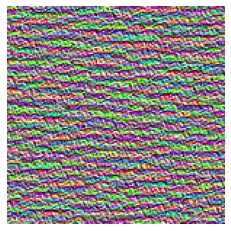

In [21]:
plt.axis("off")
# Pattern that the second channel in layer block3_sepconv1 responds to maximally
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

It seems that filter 0 in layer block3_sepconv1 is responsive to a horizontal lines pattern, somewhat water-like or fur-like. <br>
Now the fun part: you can start visualizing every filter in the layer, and even every filter in every layer in the model.

##### Generating a grid of all filter response patterns in a layer

In [22]:
all_images = []

# Generate and save visualizations for the first 64 filters in the layer.
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

# Prepare a blank canvas for us to paste filter visualizations on.
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with the saved filters.
for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

# Save the canvas to disk.
keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

![](filters_for_layer_block3_sepconv1.png)

These filter visualizations tell you a lot about how convnet layers see the world: each layer in a convnet learns a collection of filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as you go deeper in the model:
- The filters from the first layers in the model encode simple directional edges and colors (or colored edges, in some cases).
- The filters from layers a bit further up the stack, such as block4_sepconv1, encode simple textures made from combinations of edges and colors.
- The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on.

#### Visualizing heatmaps of class activation
- We’ll introduce one last visualization technique—one that is useful for understanding which parts of a given image led a convnet to its final classification decision. 
  - This is helpful for “debugging” the decision process of a convnet, particularly in the case of a classification mistake (a problem domain called **model interpretability**). 
  - It can also allow you to locate specific objects in an image.
- This general category of techniques is called **class activation map** (CAM) visualization, and it consists of producing heatmaps of class activation over input images. 
  - A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration. 
  - For instance, given an image fed into a dogs-versus-cats convnet, CAM visualization would allow you to generate a heatmap for the class “cat,” indicating how cat-like different parts of the image are, and also a heatmap for the class “dog,” indicating how dog-like parts of the image are.
- The specific implementation we’ll use is the one described in an article titled “**Grad-CAM**: Visual Explanations from Deep Networks via Gradient-based Localization.”
- **Grad-CAM** consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel. Intuitively, one way to understand this trick is to imagine that you’re weighting a spatial map of “how intensely the input image activates different channels” by “how important each channel is with regard to the class,” resulting in a spatial map of “how intensely the input image activates the class.”

Let’s demonstrate this technique using the pretrained Xception model.

##### Loading the Xception network with pretrained weights

In [23]:
model = keras.applications.xception.Xception(weights="imagenet") # Note that we include the densely connected classifier on top; in all previous cases, we discarded it.

91897856/91884032 [==============================] - 55s 1us/step


Consider the image of two African elephants shown in figure 9.18, possibly a mother and her calf, strolling on the savanna. <br>
Let’s convert this image into something the Xception model can read: the model was trained on images of size 299 × 299, preprocessed according to a few rules that are packaged in the **keras.applications.xception.preprocess_input utility** function. <br>So we need to load the image, resize it to 299 × 299, convert it to a NumPy float32 tensor, and apply these preprocessing rules.

![](./chapter_images/9.18.png)

##### Preprocessing an input image for Xception

In [24]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg") # Download the image and store it locally under the path img_path.

def get_img_array(img_path, target_size):
    # Return a Python Imaging Library (PIL) image of size 299 × 299.
    img = keras.utils.load_img(img_path, target_size=target_size)
    # Return a float32 NumPy array of shape (299, 299, 3).
    array = keras.utils.img_to_array(img)
    # Add a dimension to transform the array into a batch of size (1, 299, 299, 3).
    array = np.expand_dims(array, axis=0)
    # Preprocess the batch (this does channel-wise color normalization).
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

745472/733657 [==============================] - 1s 1us/step


You can now run the pretrained network on the image and decode its prediction vector back to a human-readable format:

In [25]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 0s 1us/step
[('n02504458', 'African_elephant', 0.8699401), ('n01871265', 'tusker', 0.07695615), ('n02504013', 'Indian_elephant', 0.023541745)]


The top three classes predicted for this image are as follows:
- African elephant (with 87% probability)
- Tusker (with 7% probability)
- Indian elephant (with 2% probability)

The network has recognized the image as containing an undetermined quantity of African elephants. The entry in the prediction vector that was maximally activated is the one corresponding to the “African elephant” class, at index 386:

In [26]:
np.argmax(preds[0])

386

To visualize which parts of the image are the most African-elephant–like, let’s set up the **Grad-CAM** process. <br>
First, we create a model that maps the input image to the activations of the last convolutional layer.

##### Setting up a model that returns the last convolutional output

In [27]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

Second, we create a model that maps the activations of the last convolutional layer to the final class predictions.

##### Reapplying the classifier on top of the last convolutional output

In [28]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

Then we compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer.

##### Retrieving the gradients of the top predicted class

In [29]:
import tensorflow as tf

with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it.
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Retrieve the activation channel corresponding to the top predicted class.
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to the output feature map of the last convolutional layer.
grads = tape.gradient(top_class_channel, last_conv_layer_output)

Now we apply pooling and importance weighting to the gradient tensor to obtain our heatmap of class activation.

##### Gradient pooling and channel-importance weighting

In [30]:
# This is a vector where each entry is the mean intensity of the gradient for a given channel. It quantifies the importance of each channel with regard to the top predicted class.
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
# Multiply each channel in the output of the last convolutional layer by “how important this channel is.”
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
# The channel-wise mean of the resulting feature map is our heatmap of class activation.
heatmap = np.mean(last_conv_layer_output, axis=-1)

For visualization purposes, we’ll also normalize the heatmap between 0 and 1. The result is shown below.

##### Heatmap post-processing

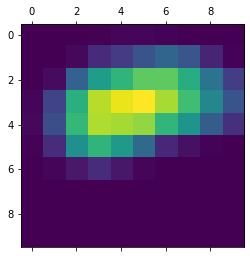

In [31]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
# Standalone class activation heatmap

Finally, let’s generate an image that superimposes the original image on the heatmap we just obtained.

##### Superimposing the heatmap on the original picture

In [32]:
import matplotlib.cm as cm

# Load the original image.
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

# Rescale the heatmap to the range 0–255.
heatmap = np.uint8(255 * heatmap)

# Use the "jet" colormap to recolorize the heatmap.
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image that contains the recolorized heatmap.
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# Superimpose the heatmap and the original image, with the heatmap at 40% opacity.
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

# Save the superimposed image.
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

![](elephant_cam.jpg)

This visualization technique answers two important questions:
- Why did the network think this image contained an African elephant?
- Where is the African elephant located in the picture?

In particular, it’s interesting to note that the ears of the elephant calf are strongly activated: this is probably how the network can tell the difference between African and Indian elephants.

#### Summary
- There are three essential computer vision tasks you can do with deep learning: image classification, image segmentation, and object detection.
- Following modern convnet architecture best practices will help you get the most out of your models. Some of these best practices include using residual connections, batch normalization, and depthwise separable convolutions.
- The representations that convnets learn are easy to inspect—convnets are the opposite of black boxes!
- You can generate visualizations of the filters learned by your convnets, as well as heatmaps of class activity.